In [12]:
import numpy as np 
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn import metrics
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    roc_auc_score
)
import matplotlib.pyplot as plt
from scipy.sparse import issparse

#### Encoding and data split

In [13]:
def encode(df):
    """
    Encodes the dataset using one-hot encoding for general categorical columns and 
    ordinal encoding for specified columns with predefined categories. Splits the data into training and test datasets.

    Parameters:
        df (pandas.DataFrame): DataFrame to encode and split.

    Returns:
      X_train_encoded (DataFrame): Encoded training features.
      X_test_encoded (DataFrame): Encoded test features.
      y_train (Series): Training target variable.
      y_test (Series): Test target variable.

    """
    # convert health days from float to int
    df['PhysicalHealthDays'] = df['PhysicalHealthDays'].astype(int)
    df['MentalHealthDays'] = df['MentalHealthDays'].astype(int)

    # Define the features and target
    X = df.drop('HadHeartDisease', axis=1)
    y = df['HadHeartDisease']
    
    # data split
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                        test_size = 0.25, 
                                        random_state = 69,
                                        stratify = df['HadHeartDisease'])
    
    # Define which columns to one-hot encode and which to label encode
    categorical_cols = X.select_dtypes(include=['object']).columns
    one_hot_cols = categorical_cols.drop(['GeneralHealth', 'LastCheckupTime', 'RemovedTeeth', 
                                          'AgeCategory', 'SmokerStatus', 'ECigaretteUsage'])
    
    

    # define the columns with specific encoding
    comp_labels = {
        "GeneralHealth": ['Poor', 'Fair', 'Good', 
                          'Very good', 'Excellent'],

        "LastCheckupTime": ['5 or more years ago',
                            'Within past 5 years (2 years but less than 5 years ago)',
                            'Within past 2 years (1 year but less than 2 years ago)',
                            'Within past year (anytime less than 12 months ago)'],

        "RemovedTeeth": ['None of them', '1 to 5',
                         '6 or more, but not all', 'All'],

        "SmokerStatus": ['Never smoked', 'Former smoker',
                         'Current smoker - now smokes some days',
                         'Current smoker - now smokes every day'],
                         
        "ECigaretteUsage": ['Never used e-cigarettes in my entire life',
                            'Not at all (right now)',
                            'Use them some days',
                            'Use them every day']
    }

    label_encoders = [(key + '_label', OrdinalEncoder(categories=[value]), [key]) 
                      for key, value in comp_labels.items()]
    
    # Define the preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('onehot', OneHotEncoder(), one_hot_cols),
            ('label', OrdinalEncoder(), ['AgeCategory']),
        ] + label_encoders
        , remainder='passthrough'
    )
    
    # Fit the preprocessor on the training data only
    X_train_encoded = preprocessor.fit_transform(X_train)
    X_test_encoded = preprocessor.transform(X_test)

    # Handle sparse matrix if necessary
    if issparse(X_train_encoded):
        X_train_encoded = X_train_encoded.toarray()
    if issparse(X_test_encoded):
        X_test_encoded = X_test_encoded.toarray()

    # Convert the sparse matrix to DataFrame and specify column names
    columns = preprocessor.get_feature_names_out()
    X_train_encoded = pd.DataFrame(X_train_encoded, columns=columns, index=X_train.index)
    X_test_encoded = pd.DataFrame(X_test_encoded, columns=columns, index=X_test.index)

    return X_train_encoded, X_test_encoded, y_train, y_test


Test encode() on `df_heart_drop_03_imp`

In [14]:
df_heart_drop_03_imp = pd.read_csv('../../Data/GoogleDrive/df_heart_drop_03_imp.csv')
# display all columns
pd.set_option('display.max_columns', None)
df_heart_drop_03_imp

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadAsthma,HadSkinCancer,HadCOPD,HadDepressiveDisorder,HadKidneyDisease,HadArthritis,HadDiabetes,DeafOrHardOfHearing,BlindOrVisionDifficulty,DifficultyConcentrating,DifficultyWalking,DifficultyDressingBathing,DifficultyErrands,SmokerStatus,ECigaretteUsage,ChestScan,RaceEthnicityCategory,AgeCategory,HeightInMeters,WeightInKilograms,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos,HadHeartDisease
0,Alabama,Female,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,None of them,No,No,No,No,No,No,Yes,No,No,No,No,No,No,Never smoked,Not at all (right now),No,"White only, Non-Hispanic",Age 80 or older,1.70,81.19,No,No,Yes,No,"Yes, received tetanus shot but not sure what type",No,No,No
1,Alabama,Female,Excellent,0.0,0.0,Within past year (anytime less than 12 months ...,No,6.0,None of them,No,Yes,No,No,No,No,No,No,No,No,No,No,No,Never smoked,Never used e-cigarettes in my entire life,No,"White only, Non-Hispanic",Age 80 or older,1.60,68.04,No,No,No,No,"No, did not receive any tetanus shot in the pa...",No,No,No
2,Alabama,Female,Very good,2.0,3.0,Within past year (anytime less than 12 months ...,Yes,5.0,None of them,No,Yes,No,No,No,No,No,No,No,No,No,No,No,Never smoked,Never used e-cigarettes in my entire life,No,"White only, Non-Hispanic",Age 55 to 59,1.57,63.50,No,No,No,No,"No, did not receive any tetanus shot in the pa...",No,Yes,No
3,Alabama,Female,Excellent,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,7.0,None of them,Yes,No,No,No,No,Yes,No,No,No,No,No,No,No,Current smoker - now smokes some days,Never used e-cigarettes in my entire life,Yes,"White only, Non-Hispanic",Age 65 to 69,1.65,63.50,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No,No
4,Alabama,Female,Fair,2.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,No,No,No,No,No,No,No,No,No,No,No,No,Never smoked,Never used e-cigarettes in my entire life,Yes,"White only, Non-Hispanic",Age 40 to 44,1.57,53.98,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385489,Virgin Islands,Male,Good,0.0,0.0,Within past 2 years (1 year but less than 2 ye...,Yes,8.0,None of them,No,No,No,No,No,No,No,No,No,No,No,No,No,Never smoked,Never used e-cigarettes in my entire life,No,"White only, Non-Hispanic",Age 30 to 34,1.83,104.33,Yes,No,No,No,"No, did not receive any tetanus shot in the pa...",No,Yes,No
385490,Virgin Islands,Female,Good,0.0,3.0,Within past 2 years (1 year but less than 2 ye...,Yes,6.0,None of them,Yes,No,No,Yes,No,No,No,No,No,No,No,No,No,Never smoked,Never used e-cigarettes in my entire life,Yes,"Black only, Non-Hispanic",Age 18 to 24,1.65,69.85,Yes,Yes,No,No,"No, did not receive any tetanus shot in the pa...",No,Yes,No
385491,Virgin Islands,Female,Excellent,2.0,2.0,Within past year (anytime less than 12 months ...,Yes,7.0,None of them,No,No,No,No,No,No,No,No,No,No,No,No,No,Never smoked,Never used e-cigarettes in my entire life,No,"Black only, Non-Hispanic",Age 50 to 54,1.70,83.01,No,Yes,Yes,No,"Yes, received tetanus shot but not sure what type",No,No,No
385492,Virgin Islands,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,5.0,None of them,Yes,No,No,No,No,No,No,No,No,No,No,No,No,Never smoked,Never used e-cigarettes in my entire life,Yes,"Black only, Non-Hispanic",Age 70 to 74,1.83,108.86,No,Yes,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes,Yes


In [15]:
# getting classes in ordinal variables
print(df_heart_drop_03_imp['GeneralHealth'].unique())
print(df_heart_drop_03_imp['LastCheckupTime'].unique())
print(df_heart_drop_03_imp['RemovedTeeth'].unique())
print(df_heart_drop_03_imp['SmokerStatus'].unique())
print(df_heart_drop_03_imp['ECigaretteUsage'].unique())
print(df_heart_drop_03_imp['AgeCategory'].unique())
# print(df_heart_drop_imp['TetanusLast10Tdap'].unique())
print(df_heart_drop_03_imp.info(max_cols=len(df_heart_drop_03_imp.columns)))

['Very good' 'Excellent' 'Fair' 'Poor' 'Good']
['Within past year (anytime less than 12 months ago)'
 'Within past 2 years (1 year but less than 2 years ago)'
 'Within past 5 years (2 years but less than 5 years ago)'
 '5 or more years ago']
['None of them' '1 to 5' '6 or more, but not all' 'All']
['Never smoked' 'Current smoker - now smokes some days' 'Former smoker'
 'Current smoker - now smokes every day']
['Not at all (right now)' 'Never used e-cigarettes in my entire life'
 'Use them every day' 'Use them some days']
['Age 80 or older' 'Age 55 to 59' 'Age 65 to 69' 'Age 40 to 44'
 'Age 75 to 79' 'Age 70 to 74' 'Age 60 to 64' 'Age 50 to 54'
 'Age 45 to 49' 'Age 35 to 39' 'Age 30 to 34' 'Age 25 to 29'
 'Age 18 to 24']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385494 entries, 0 to 385493
Data columns (total 37 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   State                      385494 non-nu

In [16]:
X_train, X_test, y_train, y_test = encode(df_heart_drop_03_imp)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(type(X_train))
print(X_train.info())

(289120, 121)
(96374, 121)
(289120,)
(96374,)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
Int64Index: 289120 entries, 95938 to 58656
Columns: 121 entries, onehot__State_Alabama to remainder__WeightInKilograms
dtypes: float64(121)
memory usage: 269.1 MB
None


#### Threshold Selection

In [18]:
# use logistic regression to select threshold
def logi_reg(X_train, X_test, y_train, y_test):
    """You know what it does 

        Input: 
            X_train: Encoded features in the training set, a pandas dataframe
            X_test: Encoded features in the test set, a pandas dataframe
            y_train: Target variable of the training set, a pandas series
            y_train: Target variable of the training set, a pandas series

        Output:
            classification_report:
            confusion_matrix:
            accuracy_score:
            roc_auc_score:
    """

    # fit logistic regression model with elastic net regularization
    log_reg = LogisticRegression(penalty = 'elasticnet',
                                solver = 'saga',
                                l1_ratio = 0.5,
                                max_iter = 1000)
    
    log_reg.fit(X_train, y_train)

    # predict on test set
    y_test_pred = log_reg.predict(X_test)
    y_pred_proba = log_reg.predict_proba(X_test)[:,1]

    # Evaluate performance
    report = classification_report(y_test, y_test_pred, target_names= ['No', 'Yes'])
    matrix = confusion_matrix(y_test, y_test_pred)
    accuracy = accuracy_score(y_test, y_test_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    return report, matrix, accuracy, roc_auc


#### Run a loop over thresholds

In [19]:
thresholds = [0, 1, 3, 5, 10, 20, 40]
# for creating plots later
roc_list = []
for threshold in thresholds:
    df = pd.read_csv(f"../../Data/GoogleDrive/df_heart_drop_{threshold:02}_imp.csv")
    X_train, X_test, y_train, y_test = encode(df)
    report, matrix, accuracy, roc_auc = logi_reg(X_train, X_test, y_train, y_test)
    roc_list.append(roc_auc)
    print (f"The threshold for removing NAs is {threshold}")
    print('\n===============================\n'+
        'Classification report on test data' +
        '\n===============================\n')
    print(report)

    print('\n===============================\n'+
        'Confusion matrix on test data' +
        '\n===============================\n')
    print(matrix)

    print("Accuracy:", accuracy)
    print("ROC AUC:", roc_auc)
    print("=====================================\n")

/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


The threshold for removing NAs is 0

Classification report on test data

              precision    recall  f1-score   support

          No       0.90      0.98      0.94     54780
         Yes       0.57      0.16      0.25      7062

    accuracy                           0.89     61842
   macro avg       0.73      0.57      0.59     61842
weighted avg       0.86      0.89      0.86     61842


Confusion matrix on test data

[[53926   854]
 [ 5952  1110]]
Accuracy: 0.8899453445878206
ROC AUC: 0.8385569594874956



/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


The threshold for removing NAs is 1

Classification report on test data

              precision    recall  f1-score   support

          No       0.90      0.98      0.94     75608
         Yes       0.56      0.16      0.25      9760

    accuracy                           0.89     85368
   macro avg       0.73      0.57      0.59     85368
weighted avg       0.86      0.89      0.86     85368


Confusion matrix on test data

[[74366  1242]
 [ 8210  1550]]
Accuracy: 0.8892793552619248
ROC AUC: 0.8384204792384707



/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


The threshold for removing NAs is 3

Classification report on test data

              precision    recall  f1-score   support

          No       0.90      0.98      0.94     85306
         Yes       0.55      0.16      0.25     11068

    accuracy                           0.89     96374
   macro avg       0.73      0.57      0.59     96374
weighted avg       0.86      0.89      0.86     96374


Confusion matrix on test data

[[83892  1414]
 [ 9310  1758]]
Accuracy: 0.888725174839687
ROC AUC: 0.8384073431651496



/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


The threshold for removing NAs is 5

Classification report on test data

              precision    recall  f1-score   support

          No       0.90      0.98      0.94     86858
         Yes       0.55      0.15      0.24     11283

    accuracy                           0.89     98141
   macro avg       0.73      0.57      0.59     98141
weighted avg       0.86      0.89      0.86     98141


Confusion matrix on test data

[[85474  1384]
 [ 9570  1713]]
Accuracy: 0.8883850786113857
ROC AUC: 0.8390552826672569



/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


The threshold for removing NAs is 10

Classification report on test data

              precision    recall  f1-score   support

          No       0.90      0.98      0.94     90858
         Yes       0.56      0.15      0.24     11801

    accuracy                           0.89    102659
   macro avg       0.73      0.57      0.59    102659
weighted avg       0.86      0.89      0.86    102659


Confusion matrix on test data

[[89434  1424]
 [10009  1792]]
Accuracy: 0.8886312938953234
ROC AUC: 0.8385804382947888



/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


The threshold for removing NAs is 20

Classification report on test data

              precision    recall  f1-score   support

          No       0.90      0.98      0.94     96863
         Yes       0.55      0.15      0.23     12447

    accuracy                           0.89    109310
   macro avg       0.73      0.57      0.59    109310
weighted avg       0.86      0.89      0.86    109310


Confusion matrix on test data

[[95371  1492]
 [10608  1839]]
Accuracy: 0.8893056444973012
ROC AUC: 0.8353993327774307



/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


The threshold for removing NAs is 40

Classification report on test data

              precision    recall  f1-score   support

          No       0.90      0.98      0.94     96924
         Yes       0.55      0.15      0.24     12454

    accuracy                           0.89    109378
   macro avg       0.73      0.57      0.59    109378
weighted avg       0.86      0.89      0.86    109378


Confusion matrix on test data

[[95398  1526]
 [10558  1896]]
Accuracy: 0.8895207445738631
ROC AUC: 0.8379490062284392



In [22]:
roc_list

[0.8385569594874956,
 0.8384204792384707,
 0.8384073431651496,
 0.8390552826672569,
 0.8385804382947888,
 0.8353993327774307,
 0.8379490062284392]

#### Bar Plot of ROC AUC against thresholds

roc auc as y-axis, thresholds as x-axis

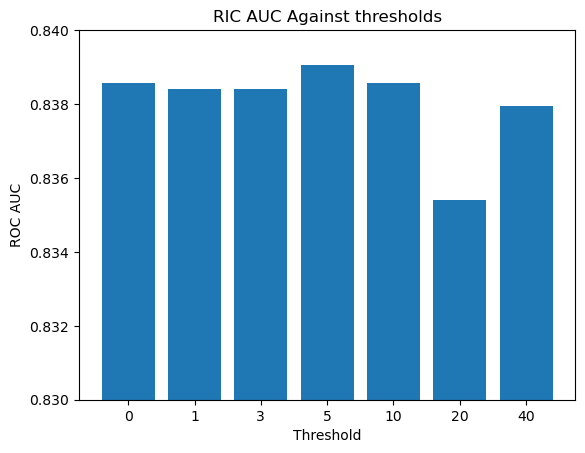

In [24]:
thresholds = [str(threshold) for threshold in thresholds]
# Create bar plot
plt.bar(thresholds, roc_list)
plt.ylim(0.83, 0.84)

# Adding the title and labels
plt.title('RIC AUC Against thresholds')
plt.xlabel('Threshold')
plt.ylabel('ROC AUC')

# Show the plot
plt.show()

Threshold = 5 results the best performance on logit.

#### Reapply encode() on the final dataset again and export

In [25]:
df_heart_drop_05_imp = pd.read_csv('../../Data/GoogleDrive/df_heart_drop_05_imp.csv')
df_heart_drop_05_imp

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadAsthma,HadSkinCancer,HadCOPD,HadDepressiveDisorder,HadKidneyDisease,HadArthritis,HadDiabetes,DeafOrHardOfHearing,BlindOrVisionDifficulty,DifficultyConcentrating,DifficultyWalking,DifficultyDressingBathing,DifficultyErrands,SmokerStatus,ECigaretteUsage,ChestScan,RaceEthnicityCategory,AgeCategory,HeightInMeters,WeightInKilograms,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos,HadHeartDisease
0,Alabama,Female,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,None of them,No,No,No,No,No,No,Yes,No,No,No,No,No,No,Never smoked,Not at all (right now),No,"White only, Non-Hispanic",Age 80 or older,1.70,80.74,No,No,Yes,No,"Yes, received tetanus shot but not sure what type",No,No,No
1,Alabama,Female,Excellent,0.0,0.0,Within past year (anytime less than 12 months ...,No,6.0,None of them,No,Yes,No,No,No,No,No,No,No,No,No,No,No,Never smoked,Never used e-cigarettes in my entire life,No,"White only, Non-Hispanic",Age 80 or older,1.60,68.04,No,No,No,No,"No, did not receive any tetanus shot in the pa...",No,No,No
2,Alabama,Female,Very good,2.0,3.0,Within past year (anytime less than 12 months ...,Yes,5.0,None of them,No,Yes,No,No,No,No,No,No,No,No,No,No,No,Never smoked,Never used e-cigarettes in my entire life,No,"White only, Non-Hispanic",Age 55 to 59,1.57,63.50,No,No,No,No,"No, did not receive any tetanus shot in the pa...",No,Yes,No
3,Alabama,Female,Excellent,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,7.0,None of them,Yes,No,No,No,No,Yes,No,No,No,No,No,No,No,Current smoker - now smokes some days,Never used e-cigarettes in my entire life,Yes,"White only, Non-Hispanic",Age 65 to 69,1.65,63.50,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No,No
4,Alabama,Female,Fair,2.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,No,No,No,No,No,No,No,No,No,No,No,No,Never smoked,Never used e-cigarettes in my entire life,Yes,"White only, Non-Hispanic",Age 40 to 44,1.57,53.98,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392556,Virgin Islands,Female,Good,0.0,3.0,Within past 2 years (1 year but less than 2 ye...,Yes,6.0,None of them,Yes,No,No,Yes,No,No,No,No,No,No,No,No,No,Never smoked,Never used e-cigarettes in my entire life,Yes,"Black only, Non-Hispanic",Age 18 to 24,1.65,69.85,Yes,Yes,No,No,"No, did not receive any tetanus shot in the pa...",No,Yes,No
392557,Virgin Islands,Female,Excellent,2.0,2.0,Within past year (anytime less than 12 months ...,Yes,7.0,None of them,No,No,No,No,No,No,No,No,No,No,No,No,No,Never smoked,Never used e-cigarettes in my entire life,No,"Black only, Non-Hispanic",Age 50 to 54,1.70,83.01,No,Yes,Yes,No,"Yes, received tetanus shot but not sure what type",No,No,No
392558,Virgin Islands,Female,Poor,30.0,30.0,5 or more years ago,No,5.0,1 to 5,No,No,No,No,No,No,No,No,No,No,No,No,No,Current smoker - now smokes every day,Use them some days,No,"White only, Non-Hispanic",Age 65 to 69,1.70,49.90,Yes,No,No,No,"No, did not receive any tetanus shot in the pa...",No,No,No
392559,Virgin Islands,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,5.0,None of them,Yes,No,No,No,No,No,No,No,No,No,No,No,No,Never smoked,Never used e-cigarettes in my entire life,Yes,"Black only, Non-Hispanic",Age 70 to 74,1.83,108.86,No,Yes,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes,Yes


In [26]:
X_train, X_test, y_train, y_test = encode(df_heart_drop_05_imp)
X_train.to_csv("../../Data/GoogleDrive/X_train.csv")
X_test.to_csv("../../Data/GoogleDrive/X_test.csv")
y_train.to_csv("../../Data/GoogleDrive/y_train.csv")
y_test.to_csv("../../Data/GoogleDrive/y_test.csv")